<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/exploration/ex_oneone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install cupy

In [ ]:
!cp /content/drive/MyDrive/colabdata/aiffel/ex_oneone/data.tar /content/data.tar
!tar xvf data.tar

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [540, 540]




ROOT_PATH = '/content'
TRAIN_PATH = ROOT_PATH + '/data/train/*/*'
VAL_PATH = ROOT_PATH + '/data/val/*/*'
TEST_PATH = ROOT_PATH + '/data/test/*/*'

In [5]:
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [7]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

In [8]:
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

In [11]:

def decode_img(img,resize=True):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if resize == True:
      img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [16]:
'''
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
'''

'\ndef show_batch(image_batch, label_batch):\n    plt.figure(figsize=(10,10))\n    for n in range(BATCH_SIZE):\n        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)\n        plt.imshow(image_batch[n])\n        if label_batch[n]:\n            plt.title("PNEUMONIA")\n        else:\n            plt.title("NORMAL")\n        plt.axis("off")\n'

In [17]:
'''
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
'''

'\nimage_batch, label_batch = next(iter(train_ds))\nshow_batch(image_batch.numpy(), label_batch.numpy())\n'

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 10, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 10, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, 10, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(256, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

In [44]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [49]:
EPOCHS = 12
BATCH_SIZE = 32

In [48]:
with tf.device('/device:GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


In [50]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/12
130/130 [==============================] - 92s 607ms/step - loss: 0.8208 - accuracy: 0.5063 - precision: 0.7360 - recall: 0.5268
Epoch 2/12
130/130 [==============================] - 79s 608ms/step - loss: 0.7249 - accuracy: 0.5534 - precision: 0.7514 - recall: 0.5952
Epoch 3/12
130/130 [==============================] - 79s 610ms/step - loss: 0.7067 - accuracy: 0.5413 - precision: 0.7367 - recall: 0.6033
Epoch 4/12
130/130 [==============================] - 79s 608ms/step - loss: 0.6998 - accuracy: 0.5418 - precision: 0.7331 - recall: 0.5949
Epoch 5/12
130/130 [==============================] - 79s 607ms/step - loss: 0.6632 - accuracy: 0.5620 - precision: 0.7514 - recall: 0.6161
Epoch 6/12
130/130 [==============================] - 79s 606ms/step - loss: 0.6615 - accuracy: 0.5750 - precision: 0.7409 - recall: 0.6574
Epoch 7/12
130/130 [==============================] - 79s 605ms/step - loss: 0.6443 - accuracy: 0.5962 - precision: 0.7563 - recall: 0.6870
Epoch 8/12
130/130 [

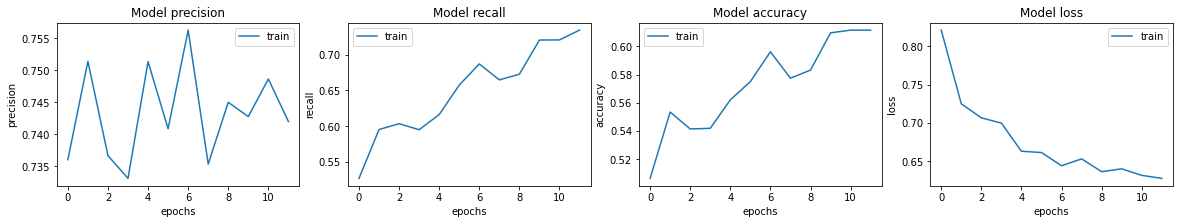

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    #ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    #ax[i].legend(['train', 'val'])
    ax[i].legend(['train'])

In [52]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 540, 540, 32)      9632      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 540, 540, 32)      102432    
_________________________________________________________________
batch_normalization_20 (Batc (None, 540, 540, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 270, 270, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 270, 270, 32)      102432    
_________________________________________________________________
batch_normalization_21 (Batc (None, 270, 270, 32)      128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 135, 135, 32)    

In [53]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 199ms/step - loss: 0.6692 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6692376136779785,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [ ]:
#model.save('/content/lmsmodel_next')
#!cp /content/lmsmodel_next /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_next

In [ ]:
#model.save('/content/lmsmodel_next_days')
#!cp /content/lmsmodel_next_days /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_next_days

In [ ]:
#model.save('/content/lmsmodel_nine')
#!mkdir /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_nine
#!cp /content/lmsmodel_nine /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_nine

In [56]:
with tf.device('/device:GPU:0'):

    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=15,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/15
130/130 [==============================] - 90s 607ms/step - loss: 0.6150 - accuracy: 0.6933 - precision: 0.7505 - recall: 0.8853
Epoch 2/15
130/130 [==============================] - 79s 607ms/step - loss: 0.6302 - accuracy: 0.6870 - precision: 0.7330 - recall: 0.9055
Epoch 3/15
130/130 [==============================] - 79s 606ms/step - loss: 0.6212 - accuracy: 0.7120 - precision: 0.7465 - recall: 0.9261
Epoch 4/15
130/130 [==============================] - 79s 607ms/step - loss: 0.6208 - accuracy: 0.6904 - precision: 0.7421 - recall: 0.8970
Epoch 5/15
130/130 [==============================] - 79s 608ms/step - loss: 0.6095 - accuracy: 0.7269 - precision: 0.7593 - recall: 0.9358
Epoch 6/15
130/130 [==============================] - 79s 608ms/step - loss: 0.6317 - accuracy: 0.6957 - precision: 0.7316 - recall: 0.9217
Epoch 7/15
130/130 [==============================] - 79s 608ms/step - loss: 0.6189 - accuracy: 0.7029 - precision: 0.7487 - recall: 0.9052
Epoch 8/15
130/130 [

In [57]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 201ms/step - loss: 0.8660 - accuracy: 0.6282 - precision: 0.6278 - recall: 0.9949
Loss: 0.8660243153572083,
Accuracy: 0.6282051205635071,
Precision: 0.6278316974639893,
Recall: 0.9948717951774597


In [58]:
with tf.device('/device:GPU:0'):


    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=10,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 90s 609ms/step - loss: 0.3439 - accuracy: 0.8361 - precision: 0.9492 - recall: 0.8231
Epoch 2/10
130/130 [==============================] - 79s 609ms/step - loss: 0.2461 - accuracy: 0.8957 - precision: 0.9677 - recall: 0.8897
Epoch 3/10
130/130 [==============================] - 79s 607ms/step - loss: 0.2160 - accuracy: 0.9115 - precision: 0.9674 - recall: 0.9129
Epoch 4/10
130/130 [==============================] - 79s 608ms/step - loss: 0.2032 - accuracy: 0.9125 - precision: 0.9669 - recall: 0.9129
Epoch 5/10
130/130 [==============================] - 79s 609ms/step - loss: 0.1840 - accuracy: 0.9212 - precision: 0.9761 - recall: 0.9171
Epoch 6/10
130/130 [==============================] - 79s 607ms/step - loss: 0.1950 - accuracy: 0.9226 - precision: 0.9642 - recall: 0.9297
Epoch 7/10
130/130 [==============================] - 79s 608ms/step - loss: 0.1918 - accuracy: 0.9212 - precision: 0.9761 - recall: 0.9171
Epoch 8/10
130/130 [

In [61]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 198ms/step - loss: 0.4332 - accuracy: 0.7997 - precision: 0.7978 - recall: 0.9103
Loss: 0.43318551778793335,
Accuracy: 0.7996794581413269,
Precision: 0.7977527976036072,
Recall: 0.9102563858032227


In [42]:
class_weight = {0: weight_for_0, 1: weight_for_1}

In [62]:
with tf.device('/device:GPU:0'):


    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/5
130/130 [==============================] - 90s 608ms/step - loss: 0.1463 - accuracy: 0.9341 - precision: 0.9791 - recall: 0.9321
Epoch 2/5
130/130 [==============================] - 79s 607ms/step - loss: 0.1668 - accuracy: 0.9341 - precision: 0.9717 - recall: 0.9381
Epoch 3/5
130/130 [==============================] - 79s 610ms/step - loss: 0.1612 - accuracy: 0.9351 - precision: 0.9764 - recall: 0.9354
Epoch 4/5
130/130 [==============================] - 79s 607ms/step - loss: 0.1445 - accuracy: 0.9438 - precision: 0.9831 - recall: 0.9405
Epoch 5/5
130/130 [==============================] - 79s 607ms/step - loss: 0.1475 - accuracy: 0.9457 - precision: 0.9812 - recall: 0.9450


In [64]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
#/2.3,2.0 epoch 15, 2.0,2.0 epoch 15,10,5

39/39 [==============================] - 8s 202ms/step - loss: 0.3424 - accuracy: 0.8654 - precision: 0.8608 - recall: 0.9359
Loss: 0.3423686623573303,
Accuracy: 0.8653846383094788,
Precision: 0.8608490824699402,
Recall: 0.9358974099159241


In [65]:
#model.save('/content/lmsmodel_86')
#!cp /content/lmsmodel_86 /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_86

INFO:tensorflow:Assets written to: /content/lmsmodel_86/assets
cp: -r not specified; omitting directory '/content/lmsmodel_86'


In [69]:
with tf.device('/device:GPU:0'):


    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=2,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/2
130/130 [==============================] - 90s 608ms/step - loss: 0.1463 - accuracy: 0.9346 - precision: 0.9797 - recall: 0.9317
Epoch 2/2
130/130 [==============================] - 79s 607ms/step - loss: 0.1173 - accuracy: 0.9495 - precision: 0.9864 - recall: 0.9448


In [70]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
(epoch 2x2)

39/39 [==============================] - 8s 205ms/step - loss: 0.5107 - accuracy: 0.7965 - precision: 0.7625 - recall: 0.9795
Loss: 0.5107117295265198,
Accuracy: 0.7964743375778198,
Precision: 0.7624750733375549,
Recall: 0.9794871807098389
